### This is a playground to experiment code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from dot import viz
import torch

from typing import Union

In [2]:
a = 5
b = 9
c = 10

y = a * b + c

print(y)

55


In [46]:
class Value:
    # data should be simple numeric value (e.g. int or float)
    def __init__(self, data, prevs=[], ops='', label=''):
        self.data = data
        self.prevs = prevs
        self.ops = ops
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return str(f'Value(data: {self.data})')

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        result = Value(self.data + other.data, [self, other], '+')

        def add_backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = add_backward
        return result
    
    def __radd__(self, other):
        return self + Value(other)

    def __sub__(self, other):
        result = Value(self.data - other.data, [self, other], '-')

        def sub_backward():
            self.grad += 1.0 * result.grad
            other.grad += -1.0 * result.grad
        result._backward = sub_backward
        return result
    
    def __rsub__(self, other):
        return Value(other) - self

    def __mul__(self, other):
        result = Value(self.data * other.data, [self, other], '*')

        def mul_backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = mul_backward

        return result

    def __truediv__(self, other):
        result = Value(self.data / other.data, [self, other], '/')

        def truediv_backward():
            self.grad += math.pow(other.data, -1) * result.grad
            other.grad += -self.data * \
                math.pow(other.data, -2) * result.grad
        result._backward = truediv_backward

        return result

    def __pow__(self, other, modulo=None):
        result = Value(math.pow(self.data, other), [self, Value(other)], '**')

        def pow_backward():
            self.grad += other * \
                math.pow(self.data, other - 1) * result.grad
        result._backward = pow_backward

        return result

    def exp(self):
        exp = math.exp(self.data)
        result = Value(exp, [self], 'exp')

        def exp_backward():
            self.grad += exp * result.grad
        result._backward = exp_backward

        return result

    def backward(self):
        self.grad = 1.0
        visited = set()
        topo = []

        def DFS(cur):
            if cur in visited:
                return
            visited.add(cur)
            for prev in cur.prevs:
                DFS(prev)
            topo.append(cur)
            
        DFS(self)
        for node in reversed(topo):
            node._backward()

    def id(self):
        return str(id(self))

In [8]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
d = a * b
d.label = 'd'
g = e / f
g.label = 'g'
y = d + c - g
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 54.266666666666666)
a.grad: 9.0
b.grad: 5.0
c.grad: 1.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


In [7]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

dt = at * bt
yt = dt + ct - et / ft

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}') 
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: 54.266666412353516
at.grad: 9.0
bt.grad: 5.0
ct.grad: 1.0
et.grad: -0.06666667014360428
ft.grad: 0.04888888821005821


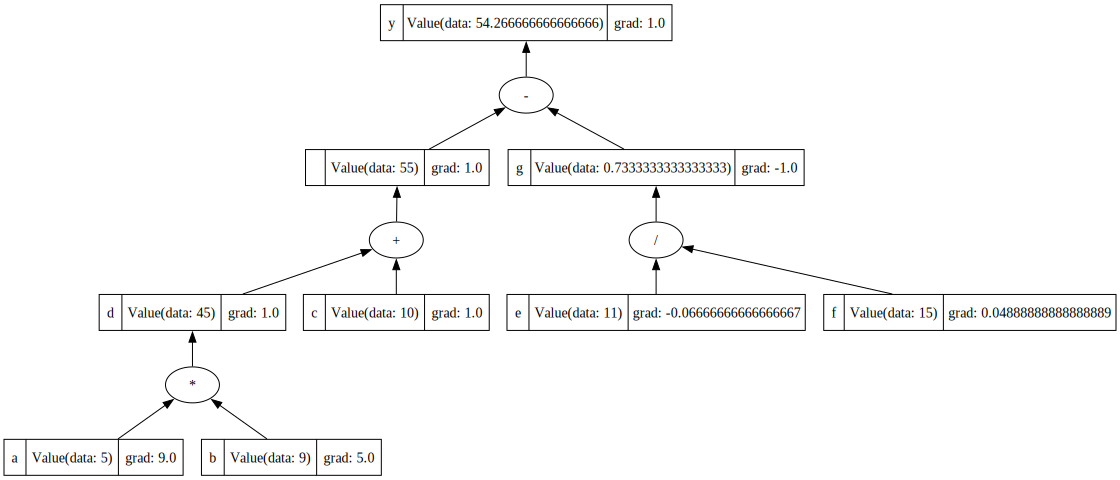

In [9]:
dot = viz.generate_graph(y)
dot

In [11]:
at = torch.tensor(5.0, requires_grad=True)
bt = torch.tensor(9.0, requires_grad=True)
ct = torch.tensor(10.0, requires_grad=True)
et = torch.tensor(11.0, requires_grad=True)
ft = torch.tensor(15.0, requires_grad=True)

yt = at * bt + ct - et / ft + at * ct**2

yt.backward()

print(f'yt: {yt}')
print(f'at.grad: {at.grad}')
print(f'bt.grad: {bt.grad}')
print(f'ct.grad: {ct.grad}')
print(f'et.grad: {et.grad}')
print(f'ft.grad: {ft.grad}')

yt: inf
at.grad: inf
bt.grad: inf
ct.grad: inf
et.grad: -inf
ft.grad: inf


In [12]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
e = Value(11, label='e')
f = Value(15, label='f')
y = a * b + c - e / f + a * c**2
y.label = 'y'

y.backward()

print(y)
print(f'a.grad: {a.grad}')
print(f'b.grad: {b.grad}')
print(f'c.grad: {c.grad}')
print(f'e.grad: {e.grad}')
print(f'f.grad: {f.grad}')

Value(data: 554.2666666666667)
a.grad: 109.0
b.grad: 5.0
c.grad: 101.0
e.grad: -0.06666666666666667
f.grad: 0.04888888888888889


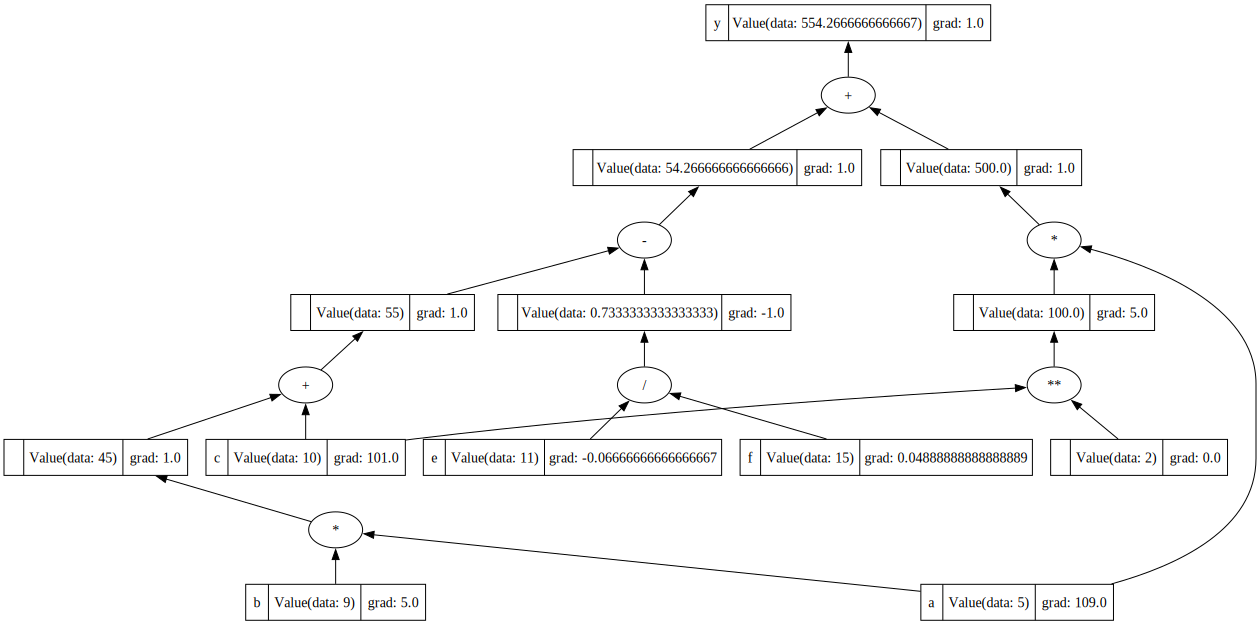

In [36]:
dot = viz.generate_graph(y)
dot

In [18]:
at = torch.tensor(5.0, requires_grad=True)
(at*2).exp()

tensor(22026.4648, grad_fn=<ExpBackward0>)

In [19]:
a = Value(5)
(a*Value(2)).exp()

Value(data: 22026.465794806718)

In [20]:
at = torch.tensor(5.0, requires_grad=True)
yt = (at*2).exp()
yt.backward()
at.grad

tensor(44052.9297)

In [22]:
a = Value(5)
y = (a*Value(2)).exp()
y.backward()
a.grad

44052.931589613436

In [53]:
def tanh(x):
    exp = math.exp(x.data * 2)
    out = (exp - 1) / (exp + 1)
    result = Value(out, prevs=[x], ops='tanh')

    def tanh_backward():
        x.grad = 1 - out ** 2
    result._backward = tanh_backward
    return result


def tanh_raw(x):
    x2exp = (x * Value(2)).exp()
    return (x2exp - Value(1)) / (x2exp + Value(1))

In [54]:
a = Value(3, label='a')
y = tanh(a)
y.label='y'
print(y)
y.backward()
print(a.grad)
print(1 - y.data ** 2)

Value(data: 0.9950547536867305)
0.009866037165440211
0.009866037165440211


In [37]:
at = torch.tensor(3.0, requires_grad=True)
yt = torch.tanh(at)
print(yt)
yt.backward()
print(at.grad)

tensor(0.9951, grad_fn=<TanhBackward0>)
tensor(0.0099)


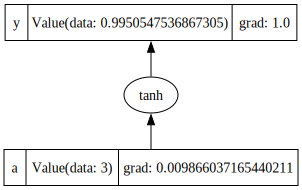

In [55]:
dot = viz.generate_graph(y)
dot

In [ ]:
a = Value (5)
y1 = 1 - a
y2 = 1 + a

print(y1)
print(y2)